# Imports and Packages

In [336]:
import os
import sys
sys.path.insert(0, os.path.join(os.getcwd(), ".."))

import torch
from torch import distributions
from torch import nn
from torch.utils import data
from sklearn import datasets

import random
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
import project
from project.utils import *
from project.models.ising import IsingModel
from project.models.sho   import SHOModel
import project.networks.net as net

%matplotlib inline
%load_ext autoreload
%autoreload 2 # Reload all modules every time before executing the Python code typed.

np.random.seed(seed=0)
torch.manual_seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Trivial Model (two beads in a 1D box connected by a spring)

The goal of this notebook is to construct a trivially "easy" system for which we can analytically solve for the latent space transformation (x to z) which maps the Boltzmann distribution in the coordinate space (x) to a Normal distribution in the latent space (z).

Consider a system of two beads in a 1D box, with spatial coordinates x1 and x2. Let a spring with spring constant k and rest length zero connect the two beads. Also, for simplicity, let us confine bead #1 within some length L. The Hamiltonian for this system is:

$$ H(x_1,x_2;k) = 
\begin{cases}
k\,(x_2-x_1)^2 ~~&~~ \text{if  } 0 \leq x_1 \leq L \\
\infty ~~&~~ \text{otherwise}
\end{cases}$$

In [337]:
# Hamiltonian for System (deal with confinement by adjusting domain of x1, later)
def H(x1,x2,k):
    return (k*(x2-x1)**2)

The equilibrium distribution of this trivial system is given by the Boltzmann distribution. Since this potential is easy, we can go ahead and normalize the distribution right away. 

$$
Z = \int_{-\infty}^\infty dx_2 \int_0^L dx_1 \, {\rm exp} \left( -k (x_2 - x_1)^2 \right) 
  = \sqrt{ \frac{\pi L^2}{k} }
$$

In [338]:
# Boltzmann Distribution
def boltzmann(E,L,k,beta=1):
    return np.exp(-beta*E)/(np.sqrt(np.pi*L*L/k))

Let's visualize the probability distribution in the x1-x2 space:

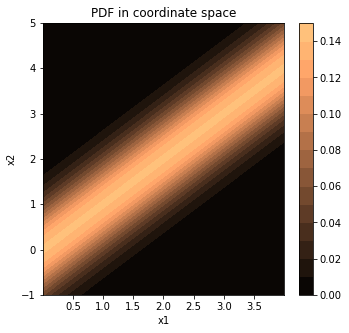

In [339]:
# Domain 
k = 1
L = 4
n = 1001

# x1 is constrained by 0 to L
x1space = np.linspace(0+0.0000001,L-0.0000001,n)
x2space = np.linspace(-5,L+5,n)
X1,X2 = np.meshgrid(x1space,x2space)
P = boltzmann(H(X1,X2,k),L,k)

# Plot
plt.figure(figsize=(5.4,5))
plt.title('PDF in coordinate space')
plt.xlabel('x1')
plt.ylabel('x2')
plt.ylim([-1,L+1])
plt.contourf(X1,X2,P,15,cmap='copper')
plt.colorbar()

We would like to solve for a transformation from coordinate space (x1, x2) to latent space (z1, z2) such that the PDF in the latent space is a normal distribution.

I obtain the following transformations when I solve (sorry I did this on paper -- Kevin):

$$ \begin{align*}
z_1 &= \Phi^{-1} \left( \frac{x_1}{L} \right) \\
z_2 &= \sqrt{2k}\,|\,x_2-x_1|  
\end{align*} $$

Above, $\Phi$ is the inverse Gaussian cumulative distribution function.

In [340]:
# Transform coordinates
Z1 = norm.ppf(X1/L)
Z2 = np.sqrt(2.0*k)*(X2 - X1)

Since the transformation above is not affine (non-linear), we need to reweight the probability distribution in latent space (z1, z2). This is accomplished by enforcing the following equality.

$$ p({\bf x})\,d{\bf x} = \bar{p}({\bf z})\,d{\bf z} $$

Above, ${\bf x} = (x_1,x_2)$ and ${\bf z} = (z_1,z_2)$ are vector quantities.

To compute the transformed distribution in latent space, we need the Jacobian $d {\bf z}/d {\bf x}$.

It is first helpful to differentiate the inverse Gaussian CDF.

$$ \begin{align*}
\frac{d \Phi^{-1}(x)}{dx} 
&= \left( \frac{dx}{d\,(\Phi^{-1} (x))} \right)^{-1} 
 = \left( \frac{d\,\left[\Phi(\Phi^{-1} (x))\right]}{d (\Phi^{-1}(x))}\right)^{-1} \\
&= \frac{1}{\phi\left( \Phi^{-1}(x) \right)}
\end{align*} $$ 

Above, $\phi = \Phi'$ is the Gaussian PDF.

Using this result, the Jacobian matrix is:
$$ J \equiv 
\begin{bmatrix}
\frac{\partial z_1}{\partial x_1} & \frac{\partial z_1}{\partial x_2} \\
\frac{\partial z_2}{\partial x_1} & \frac{\partial z_2}{\partial x_2}
\end{bmatrix} = 
\begin{bmatrix}
\frac{1}{L\,\phi \left( \Phi^{-1} (x_1/L) \right)} & 0 \\
-\sqrt{2k} & \sqrt{2k} 
\end{bmatrix}$$

$$ \text{det}(J) = \frac{\sqrt{2k}}{L\,\phi \left( z_1 \right)} $$

Thus, we must rescale the probability distribution according to:

$$ \bar{p}({\bf z}) = \left( \frac{L\,\phi \left( z_1 \right)}{\sqrt{2k}} \right) p({\bf x})$$

We visualize the latent space distribution below:

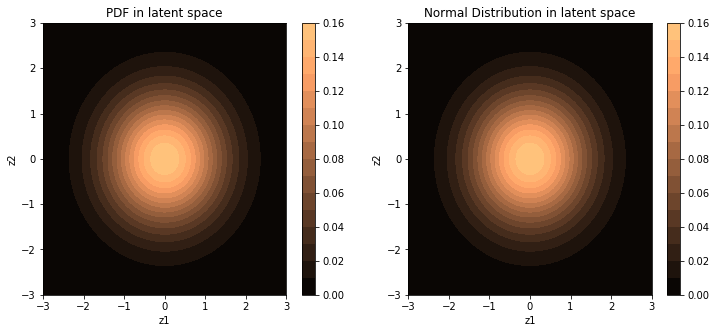

In [341]:
# Reweight the PDF
PZ = P*L*(norm.pdf(Z1))/(np.sqrt(2.0*k))

# 2D normal distribution for comparison
G = np.exp(-0.5*(np.power(Z1,2)+np.power(Z2,2)))/(2.0*np.pi)

# Visualize
stdevs = 3
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

ax1.set_title('PDF in latent space')
ax1.set(xlabel='z1', ylabel='z2', xlim=[-stdevs,stdevs], ylim=[-stdevs,stdevs]) 
im = ax1.contourf(Z1,Z2,PZ,15,cmap='copper')
fig.colorbar(im, ax=ax1);

ax2.set_title('Normal Distribution in latent space')
ax2.set(xlabel='z1', ylabel='z2', xlim=[-stdevs,stdevs], ylim=[-stdevs,stdevs])
im = ax2.contourf(Z1,Z2,G,15,cmap='copper')
fig.colorbar(im, ax=ax2);

## Inversion (sample from latent space)

Let's check to see that the reverse works too. The inverted transformation is defined by:

$$ \begin{align*}
x_1 &= L \, \Phi (z_1) \\ 
x_2 &= L \, \Phi (z_1) + \frac{z_2}{\sqrt{2k}}
\end{align*} $$

$$ p({\bf x}) = \left( \frac{\sqrt{2k}}{L\,\phi \left( \Phi^{-1} (x_1/L) \right)} \right) \bar{p} ({\bf z}) $$

Let's use a uniformly spaced grid in the latent space to do the backwards conversion.

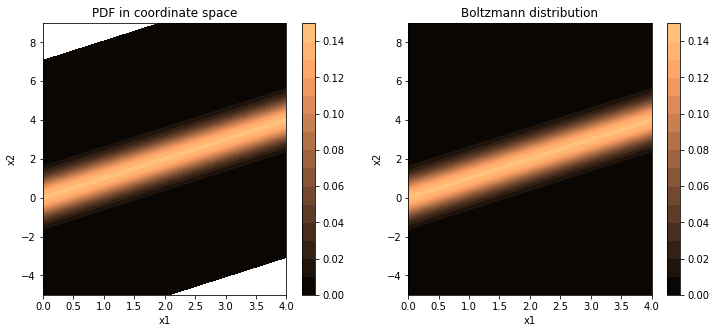

In [342]:
# Make the grid
stdevs = 10
Z1inv, Z2inv = np.meshgrid( np.linspace(-stdevs,stdevs,n), np.linspace(-stdevs,stdevs,n))
Ginv = np.exp(-0.5*(np.power(Z1inv,2)+np.power(Z2inv,2)))/(2.0*np.pi)

# Invert the distribution
X1inv = L*norm.cdf(Z1inv)
X2inv = X1inv + Z2inv/(np.sqrt(2.0*k))
Pinv  = (np.sqrt(2*k)/(L*norm.pdf(Z1inv)))*Ginv

# Visualize
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

ax1.set_title('PDF in coordinate space')
ax1.set(xlabel='x1', ylabel='x2', xlim=[0,L], ylim=[-5,L+5]) 
im = ax1.contourf(X1inv,X2inv,Pinv,15,cmap='copper')
fig.colorbar(im, ax=ax1);

ax2.set_title('Boltzmann distribution')
ax2.set(xlabel='x1', ylabel='x2', xlim=[0,L], ylim=[-5,L+5])
im = ax2.contourf(X1,X2,P,15,cmap='copper')
fig.colorbar(im, ax=ax2);

So some notes:

The deep machine learning framework should theoretically learn the transformation between x and z defined above, since for this trivial example a perfect functional form exists. The network must be expressive enough to approximate the Gaussian CDF function, which is non-linear and non-analytical (requires an error function).

So first - I would assume that in general such a transformation always exists. The intuition here is that we are preserving the dimension of the initial space. We can theoretically map each degree of freedom to an independent Gaussian, which can be combined to make a multivariate normal distribution with identity covariance. Mathematically then, one of the interesting parts of this transformation is fitting the covariance matrix. An identity covariance matrix indicates that no degrees of freedom can be removed. I suspect in the limit that L goes to infinity, or k goes to infinity, the fitting here cannot be accomplished without correlating the two variables in latent space. Said differently, if z1 = z2, then we know that there is only one true degree of freedom in the system. This suggests taht any analysis of the order parameter will revolve around the efficacy of fit to the covariance matrix. I haven't given the paper a close look, but if we set it as a hyperparameter we could learn a lot. 

Second, if you look at the math, the network could accomplish it's goal (zero loss) by learning a transformation to any rotation of z1 and z2. However, for this trivial example, this is the only rotation of z1 and z2 that makes intuitive sense. One latent coordinate represents the position of particle 1 (z1) and the other represents the bond distance (z2). Any pure rotation in z1 and z2 produces the same distribution, however, due to the rotational symmetry of the normal distribution (with identity covariance). Thus, we may *lose* information on learning, since we can no longer cleanly separate the two. It would be interesting if we could account for this somehow, i.e., how do we tell the network to look for an intuitive parameterization.

tl;dr

Let's run the methodology in the paper on this example.

My intuition is that we should use the covariance matrix as a hyperparameter. It should give us physical insight into the systems we simulate, and we might be able to establish some metrics.

## Try Boltzmann Generators

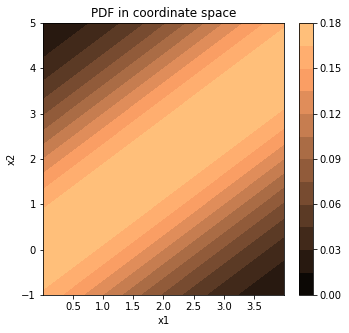

In [369]:
# Parameters
k = 0.5 # spring constant. 0.5 is probably lowest we would want to go. 
L = 4 # size of box 
n = 1001 # discretization of domain 

# Source probability distribution (real space)
x1space = np.linspace(0+0.0000001,L-0.0000001,n)
x2space = np.linspace(-5,L+5,n)
X1,X2 = np.meshgrid(x1space,x2space)
P = boltzmann(H(X1,X2,k),L,k)
plt.figure(figsize=(5.4,5))
plt.title('PDF in coordinate space')
plt.xlabel('x1')
plt.ylabel('x2')
plt.ylim([-1,L+1])
plt.contourf(X1,X2,P,15,cmap='copper')
plt.colorbar()

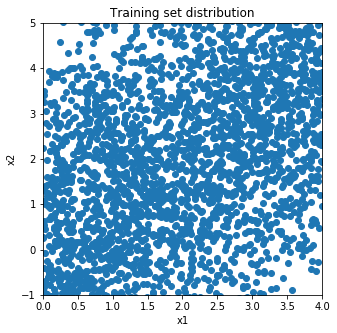

In [370]:
# Create a training set
train_set_size = 128*25 # 25 batches, where each batch is of size 128 

# x1 is a uniformly distributed variable from 0 to L, and
# (x2-x1) is Gaussian distributed with zero mean and stdev of (2k)^-0.5 (to recapitulate the Boltzmann distribution)
def sample(n,L,k):
    x1 = L*np.random.random((n,1))
#     x2 = x1 + np.random.normal(scale=np.power(2*k,-0.5),size=(n,1)) # scale is std. dev 
    x2 = x1 + np.random.normal(size=(n,1))/np.sqrt(2*k) 
    return np.hstack((x1,x2)).astype('float32')
    # np.hstack(): Stack arrays in sequence horizontally
    
# used for debugging
def sample1D(n,L,k):
    x1 = 2.0
    x2 = x1 + np.random.normal(size=(n,1))/np.sqrt(2*k)
    return x2.astype('float32')

# Generate training set
train_set = sample(train_set_size,L,k)

# Visualize training set
plt.figure(figsize=(5,5))
plt.title('Training set distribution')
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim([0,L])
plt.ylim([-1,L+1])
plt.scatter(train_set[:,0],train_set[:,1])

### Debugging discrepancy between discrete sampling and analytical pdf

I'd like to check that there is no bug in the `sample` function by comparing the distribution of the sampled points to that of the analytical distribution.

In [371]:
def boltzmann1D(E,L,k,beta=1):
    return np.exp(-beta*E)/(np.sqrt(np.pi/k))

Note that in the above I used the fact that the 1D the partition function for the Boltzmann distribution is given by (where $x_1$ is held fixed): 
$$
Z = \int_{-\infty}^\infty dx_2  \, {\rm exp} \left( -k (x_2 - x_1)^2 \right) 
  = \sqrt{ \frac{\pi}{k} }
$$

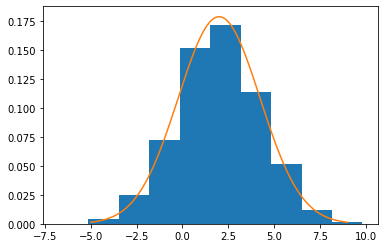

In [372]:
plt.hist(sample1D(train_set_size,L,k), density = True)

X1 = 2.0
X2 = np.linspace(-5,L+5,n)
plt.plot(X2, boltzmann1D(H(X1,X2,k),L,k))
plt.show()

### Applying boltzmann generators to the analytical example 

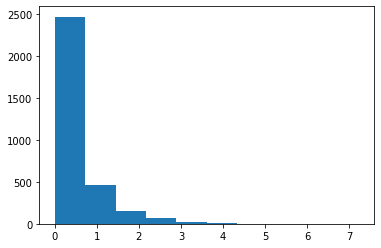

In [345]:
# Define a model
toymodel = SHOModel( params= { "k" : k, 
                               "L" : L} ) 
# SHOModel: Toy simple harmonic oscillator model, two particles connected by a spring stuck in a 1D box of length L.

plt.hist(toymodel.energy(train_set))
plt.show()

In [346]:
# Define the network architecture
n_hidden = 100 # number of hidden layers
nets = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2), nn.Tanh()) # net s
nett = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2)) # net t
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32)) # 6x2 matrix. len(masks) = 6 = num subblocks.
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))      # so we have a total of 3 neural blocks (see fig. 1 of boltzmann generators paper)
model = net.RealNVP(nets, nett, masks, prior, toymodel, (2,))

Text(0.5, 1.0, '$X = g(z)$')

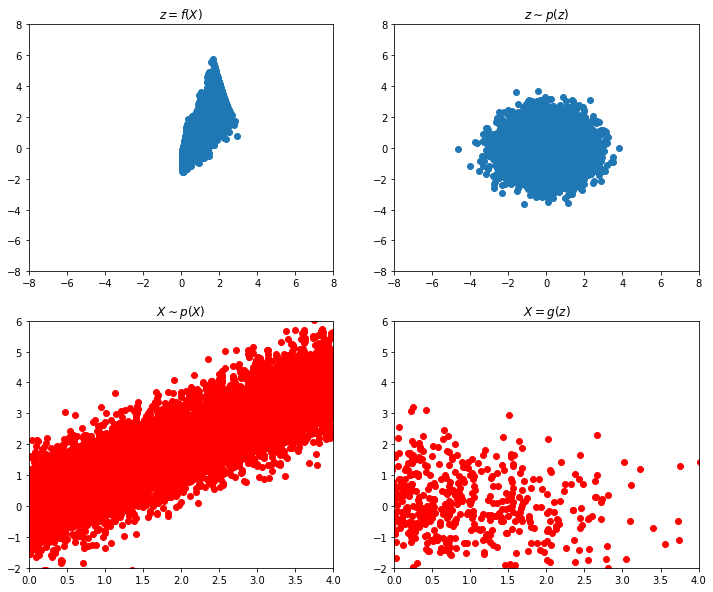

In [347]:
# Visualize the learned transformation (Before Training, with default weights)
fig, axes = plt.subplots(2, 2, figsize = (12,10))
nvis = 10000

toy_set = sample(nvis,L,k)
z = model.f(torch.from_numpy(toy_set))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$z = f(X)$')


# sampling from the multivariate gaussian with zero mean and unit variance
z = np.random.multivariate_normal(np.zeros(2), np.eye(2), nvis)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = sample(nvis,L,k)
plt.xlim([0,L])
plt.ylim([-2,L+2])
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = model.sample(1000).detach().numpy()
plt.xlim([0,L])
plt.ylim([-2,L+2])
plt.scatter(x[:,0,0], x[:,0,1], c='r')
plt.title(r'$X = g(z)$')

iter 100: loss = 0.243
iter 200: loss = 0.188


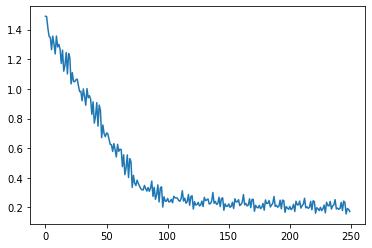

In [348]:
# Hyperparameters
num_epochs =  10 # 150 (number of iterations really) is sufficient for normal gd. 
batch_size = 128 # num_epochs = 10 and batch_size = 128 works well (and quickly) for bgd 

# Train and shit
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=0.0001) 
# need lr of 0.0001 or smaller to get monotonically decreasing loss for batch gradient descent 
trainloader = data.DataLoader(dataset=train_set, batch_size=batch_size)

#losses = np.zeros(num_epochs)
losses = [] # for visualizing loss as a function of iteration number rather than epoch number
t = 0 # iteration count
for epoch in range(num_epochs):
    for batch in trainloader:  
        # Custom ML loss function
        loss = model.loss_ml(batch) 
        losses.append(loss.item()) # save values for plotting later 
    
        # Training
        optimizer.zero_grad() # Set grads to zero, else PyTorch will accumulate gradients on each backprop
        loss.backward(retain_graph=True)
        optimizer.step()
        
        t = t + 1 # iteration count
        if t % 100 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

    # Print progress (for each epoch)
#     if epoch % 50 == 0:
#         print('Epoch %s:' % epoch, 'loss = %.3f' % loss)
        
    # Write loss once per epoch
#     losses[epoch] = loss.item() 

# Visualize loss
plt.plot(losses)

Text(0.5, 1.0, '$X = g(z)$')

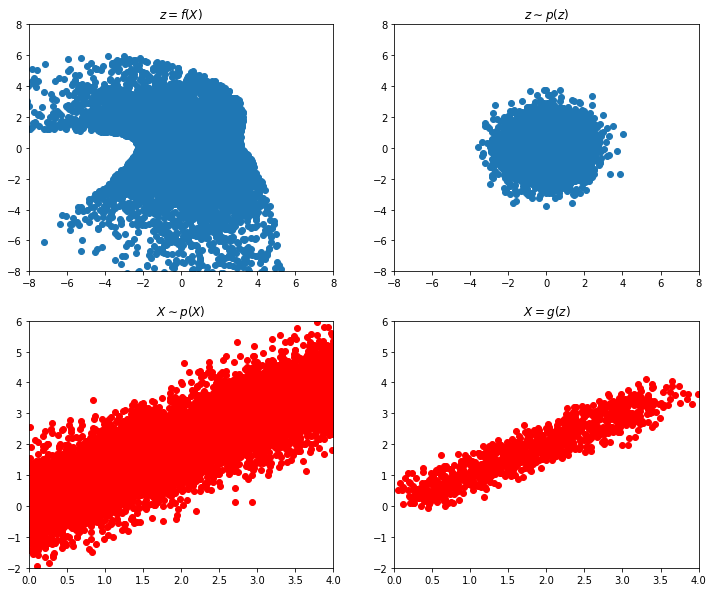

In [349]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (12,10))
nvis = 10000

# sample from x and transform to z 
toy_set = sample(nvis,L,k)
z = model.f(torch.from_numpy(toy_set))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$z = f(X)$')

# sampling from the multivariate gaussian with zero mean and unit variance
z = np.random.multivariate_normal(np.zeros(2), np.eye(2), nvis) 
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$z \sim p(z)$')

# plot data sampled in real space 
plt.subplot(223)
plt.xlim([0,L])
plt.ylim([-2,L+2])
plt.scatter(toy_set[:, 0], toy_set[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

# sample 1000 points from prior and transform back 
plt.subplot(224)
x = model.sample(1000).detach().numpy() 
plt.xlim([0,L])
plt.ylim([-2,L+2])
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')